In [87]:
import numpy as np
import os
from joblib import delayed, Parallel
import time
from analysis_funcs import rhg_lattice_scale, apply_error_channel, ParallelTqdm, find_connected_unit_cells
import networkx as nx
import matplotlib.pyplot as plt
from cluster_sim.app.grid import Grid
import pandas as pd


os.makedirs("./data", exist_ok=True)

shape = [35, 35, 200]
seed = 2

samples = 1

# Input vector for all jobs
jobs_input_vec = [(p, scale) for scale in range(1, 6) for p in np.linspace(0, 0.3, 30)]


In [88]:
def main(input_params):
    """
    Main function for parallel processing. Here, we:

    1. Create a grid of the given shape
    2. Apply the error channel to the grid
    3. Generate a RHG lattice
    4. Look at clusters of the RHG lattice
    5. Return the results

    Returns:
        - p: The input parameter for the simulation
        - percolates: The number of times percolation occurred (True: 1, False: 0)
        - times: The average time taken for the simulation
    """
    
    p, scale = input_params

    # Sanity check: check that this is equal to the move_list on the app
    # print(np.reshape(np.argwhere(removed_nodes == True), shape=-1))
    
    num_percolates = 0
    
    # store the outputs for 1 simulation
    data_out = []

    diff = 0

    for i in range(samples):
        percolate = 0
        start = time.time()
        G = Grid(shape)
        removed_nodes = np.zeros(shape[0] * shape[1] * shape[2], dtype=bool)

        G, D, removed_nodes = apply_error_channel(p, seed + i, shape, removed_nodes, G)
        # Generate an RHG lattice out of G
        G, D, removed_nodes, offsets = rhg_lattice_scale(G, D, removed_nodes, shape, scale_factor=scale)

        C = find_connected_unit_cells(G, shape, offsets, scale_factor=scale)

        if not C:
            data_out.append({
            "sample": i, 
            "p": p,
            "times": time.time() - start,
            "unit_cells": 0,
            "scale": scale,
            "percolates": 0,
            "diff" : 0
            })
            continue
        
        largest_cc = max(nx.connected_components(C), key=len)
        largest_cc = C.subgraph(largest_cc).copy()

        # Check if the largest cluster percolates
        low = np.array([np.inf, np.inf, np.inf])
        high = np.zeros(3)

        if not largest_cc:
            #print("No clusters")
            diff = 0

        else:
            for node in largest_cc.nodes:
                # Get the coordinates of the node
                low = np.minimum(low, np.array(node))
                high = np.maximum(high, np.array(node))
            diff = high[2] - low[2] 

            #print(f"high = {high}, low={low}, diff={diff}")
            if shape[2] - diff <= 2*(scale + 2):
                num_percolates += 1
                percolate = 1

        end = time.time()

        data_out.append({
        "sample": i, 
        "p": p,
        "times": end - start,
        "unit_cells": largest_cc.number_of_nodes(),
        "scale": scale,
        "percolates": percolate,
        "diff" : diff
        })

    print(f"p = {p}, percolates = {num_percolates}")

    return data_out


In [90]:
results = ParallelTqdm(n_jobs=-1)([delayed(main)(x) for x in jobs_input_vec])
results = [item for sublist in results for item in sublist]

df = pd.DataFrame(results)
df.to_csv("./data/test.csv", index=False, header=False)


  0%|          | 0/150 [00:00<?, ?tasks/s]

p = 0.07241379310344828, percolates = 1


  1%|          | 1/150 [02:16<5:39:17, 136.63s/tasks]

p = 0.06206896551724138, percolates = 1


  1%|▏         | 2/150 [02:57<3:17:31, 80.07s/tasks] 

p = 0.08275862068965517, percolates = 0


  3%|▎         | 4/150 [04:10<1:57:09, 48.14s/tasks]

p = 0.09310344827586206, percolates = 0
p = 0.05172413793103448, percolates = 1


  3%|▎         | 5/150 [04:37<1:38:21, 40.70s/tasks]

p = 0.10344827586206896, percolates = 0


  4%|▍         | 6/150 [04:47<1:12:33, 30.23s/tasks]

p = 0.11379310344827587, percolates = 0


  5%|▌         | 8/150 [05:05<46:08, 19.50s/tasks]  

p = 0.12413793103448276, percolates = 0


  6%|▌         | 9/150 [05:10<35:01, 14.90s/tasks]

p = 0.14482758620689656, percolates = 0
p = 0.13448275862068965, percolates = 0


  7%|▋         | 11/150 [05:26<27:02, 11.67s/tasks]

p = 0.15517241379310345, percolates = 0


  8%|▊         | 12/150 [05:30<21:31,  9.36s/tasks]

p = 0.16551724137931034, percolates = 0


  9%|▊         | 13/150 [05:31<15:40,  6.87s/tasks]

p = 0.17586206896551723, percolates = 0


  9%|▉         | 14/150 [05:42<18:48,  8.30s/tasks]

p = 0.18620689655172412, percolates = 0


 10%|█         | 15/150 [05:46<15:19,  6.81s/tasks]

p = 0.19655172413793104, percolates = 0


 11%|█         | 16/150 [05:47<11:21,  5.08s/tasks]

p = 0.20689655172413793, percolates = 0
p = 0.041379310344827586, percolates = 1


 12%|█▏        | 18/150 [05:59<12:58,  5.89s/tasks]

p = 0.21724137931034482, percolates = 0


 13%|█▎        | 19/150 [06:00<10:11,  4.67s/tasks]

p = 0.22758620689655173, percolates = 0


 13%|█▎        | 20/150 [06:03<08:45,  4.04s/tasks]

p = 0.23793103448275862, percolates = 0


 14%|█▍        | 21/150 [06:04<06:45,  3.15s/tasks]

p = 0.2482758620689655, percolates = 0


 15%|█▍        | 22/150 [06:15<11:27,  5.37s/tasks]

p = 0.25862068965517243, percolates = 0


 15%|█▌        | 23/150 [06:17<09:07,  4.31s/tasks]

p = 0.2689655172413793, percolates = 0


 16%|█▌        | 24/150 [06:17<06:36,  3.14s/tasks]

p = 0.2793103448275862, percolates = 0


 17%|█▋        | 25/150 [06:20<06:33,  3.15s/tasks]

p = 0.2896551724137931, percolates = 0


 17%|█▋        | 26/150 [06:30<10:46,  5.22s/tasks]

p = 0.3, percolates = 0


 18%|█▊        | 27/150 [08:04<1:05:13, 31.82s/tasks]

p = 0.010344827586206896, percolates = 1
p = 0.03103448275862069, percolates = 1


 19%|█▉        | 29/150 [08:17<38:59, 19.33s/tasks]  

p = 0.020689655172413793, percolates = 1


 20%|██        | 30/150 [08:43<42:44, 21.37s/tasks]

p = 0.0, percolates = 1
p = 0.05172413793103448, percolates = 1


 21%|██▏       | 32/150 [09:16<34:56, 17.77s/tasks]

p = 0.03103448275862069, percolates = 1
p = 0.06206896551724138, percolates = 1


 23%|██▎       | 34/150 [09:22<19:53, 10.29s/tasks]

p = 0.041379310344827586, percolates = 1


 23%|██▎       | 35/150 [09:37<22:40, 11.83s/tasks]

p = 0.07241379310344828, percolates = 1


 24%|██▍       | 36/150 [09:53<24:30, 12.90s/tasks]

p = 0.10344827586206896, percolates = 1


 25%|██▍       | 37/150 [09:54<17:38,  9.36s/tasks]

p = 0.11379310344827587, percolates = 1
p = 0.09310344827586206, percolates = 1


 26%|██▌       | 39/150 [10:02<12:12,  6.60s/tasks]

p = 0.08275862068965517, percolates = 1


 27%|██▋       | 40/150 [10:06<11:03,  6.03s/tasks]

p = 0.12413793103448276, percolates = 0


 27%|██▋       | 41/150 [10:17<13:28,  7.41s/tasks]

p = 0.14482758620689656, percolates = 0


 28%|██▊       | 42/150 [10:19<10:35,  5.89s/tasks]

p = 0.13448275862068965, percolates = 0


 29%|██▊       | 43/150 [10:20<07:48,  4.38s/tasks]

p = 0.15517241379310345, percolates = 0


 29%|██▉       | 44/150 [10:24<07:08,  4.04s/tasks]

p = 0.16551724137931034, percolates = 0


 30%|███       | 45/150 [10:28<07:27,  4.26s/tasks]

p = 0.17586206896551723, percolates = 0
p = 0.18620689655172412, percolates = 0


 31%|███▏      | 47/150 [10:41<08:26,  4.92s/tasks]

p = 0.19655172413793104, percolates = 0


 32%|███▏      | 48/150 [10:42<06:22,  3.75s/tasks]

p = 0.20689655172413793, percolates = 0


 33%|███▎      | 49/150 [10:47<06:49,  4.06s/tasks]

p = 0.21724137931034482, percolates = 0


 33%|███▎      | 50/150 [10:52<07:12,  4.32s/tasks]

p = 0.22758620689655173, percolates = 0


 34%|███▍      | 51/150 [11:02<10:13,  6.20s/tasks]

p = 0.23793103448275862, percolates = 0


 35%|███▍      | 52/150 [11:04<07:40,  4.70s/tasks]

p = 0.2482758620689655, percolates = 0


 35%|███▌      | 53/150 [11:04<05:41,  3.52s/tasks]

p = 0.25862068965517243, percolates = 0


 36%|███▌      | 54/150 [11:09<06:01,  3.76s/tasks]

p = 0.2689655172413793, percolates = 0


 37%|███▋      | 55/150 [11:16<07:46,  4.91s/tasks]

p = 0.2793103448275862, percolates = 0


 37%|███▋      | 56/150 [11:26<09:42,  6.20s/tasks]

p = 0.2896551724137931, percolates = 0


 38%|███▊      | 57/150 [11:26<06:54,  4.46s/tasks]

p = 0.020689655172413793, percolates = 1


 39%|███▊      | 58/150 [11:27<05:02,  3.29s/tasks]

p = 0.3, percolates = 0
p = 0.010344827586206896, percolates = 1


 40%|████      | 60/150 [11:39<06:55,  4.61s/tasks]

p = 0.0, percolates = 1


 41%|████      | 61/150 [11:44<07:09,  4.82s/tasks]

p = 0.020689655172413793, percolates = 1


 41%|████▏     | 62/150 [11:54<09:19,  6.35s/tasks]

p = 0.03103448275862069, percolates = 1
p = 0.041379310344827586, percolates = 1


 42%|████▏     | 63/150 [11:55<06:36,  4.56s/tasks]

p = 0.05172413793103448, percolates = 1


 43%|████▎     | 65/150 [12:05<07:20,  5.18s/tasks]

p = 0.06206896551724138, percolates = 1


 44%|████▍     | 66/150 [12:09<06:39,  4.75s/tasks]

p = 0.07241379310344828, percolates = 1
p = 0.08275862068965517, percolates = 1


 45%|████▍     | 67/150 [12:15<07:10,  5.18s/tasks]

p = 0.10344827586206896, percolates = 1


 46%|████▌     | 69/150 [12:25<06:14,  4.62s/tasks]

p = 0.09310344827586206, percolates = 1
p = 0.11379310344827587, percolates = 1


 47%|████▋     | 70/150 [12:26<04:53,  3.67s/tasks]

p = 0.12413793103448276, percolates = 1


 48%|████▊     | 72/150 [12:39<06:19,  4.86s/tasks]

p = 0.13448275862068965, percolates = 1


 49%|████▊     | 73/150 [12:45<06:28,  5.05s/tasks]

p = 0.14482758620689656, percolates = 1


 49%|████▉     | 74/150 [12:54<07:53,  6.23s/tasks]

p = 0.15517241379310345, percolates = 0


 50%|█████     | 75/150 [12:55<05:53,  4.72s/tasks]

p = 0.16551724137931034, percolates = 0


 51%|█████     | 76/150 [12:56<04:27,  3.61s/tasks]

p = 0.17586206896551723, percolates = 0


 51%|█████▏    | 77/150 [13:06<06:54,  5.68s/tasks]

p = 0.18620689655172412, percolates = 0


 52%|█████▏    | 78/150 [13:10<06:03,  5.04s/tasks]

p = 0.19655172413793104, percolates = 0


 53%|█████▎    | 79/150 [13:16<06:24,  5.42s/tasks]

p = 0.20689655172413793, percolates = 0


 53%|█████▎    | 80/150 [13:27<08:04,  6.93s/tasks]

p = 0.21724137931034482, percolates = 0


 54%|█████▍    | 81/150 [13:29<06:22,  5.54s/tasks]

p = 0.22758620689655173, percolates = 0


 55%|█████▍    | 82/150 [13:31<05:02,  4.45s/tasks]

p = 0.23793103448275862, percolates = 0


 55%|█████▌    | 83/150 [13:41<06:59,  6.25s/tasks]

p = 0.2482758620689655, percolates = 0


 56%|█████▌    | 84/150 [13:46<06:19,  5.74s/tasks]

p = 0.25862068965517243, percolates = 0


 57%|█████▋    | 85/150 [13:54<06:48,  6.29s/tasks]

p = 0.2689655172413793, percolates = 0


 57%|█████▋    | 86/150 [14:00<06:37,  6.20s/tasks]

p = 0.0, percolates = 1


 58%|█████▊    | 87/150 [14:04<05:52,  5.60s/tasks]

p = 0.2793103448275862, percolates = 0


 59%|█████▊    | 88/150 [14:06<04:52,  4.71s/tasks]

p = 0.010344827586206896, percolates = 1


 59%|█████▉    | 89/150 [14:08<03:48,  3.74s/tasks]

p = 0.2896551724137931, percolates = 0


 60%|██████    | 90/150 [14:10<03:22,  3.37s/tasks]

p = 0.3, percolates = 0


 61%|██████    | 91/150 [14:16<04:01,  4.09s/tasks]

p = 0.020689655172413793, percolates = 1
p = 0.03103448275862069, percolates = 1


 62%|██████▏   | 93/150 [14:32<05:39,  5.95s/tasks]

p = 0.041379310344827586, percolates = 1


 63%|██████▎   | 94/150 [14:36<04:59,  5.35s/tasks]

p = 0.05172413793103448, percolates = 1


 63%|██████▎   | 95/150 [14:38<04:00,  4.37s/tasks]

p = 0.06206896551724138, percolates = 1


 64%|██████▍   | 96/150 [14:44<04:25,  4.92s/tasks]

p = 0.07241379310344828, percolates = 1


 65%|██████▍   | 97/150 [14:53<05:18,  6.02s/tasks]

p = 0.08275862068965517, percolates = 1


 65%|██████▌   | 98/150 [15:03<06:16,  7.24s/tasks]

p = 0.09310344827586206, percolates = 1


 66%|██████▌   | 99/150 [15:08<05:46,  6.79s/tasks]

p = 0.10344827586206896, percolates = 1


 67%|██████▋   | 100/150 [15:15<05:35,  6.72s/tasks]

p = 0.11379310344827587, percolates = 1


 67%|██████▋   | 101/150 [15:18<04:36,  5.63s/tasks]

p = 0.12413793103448276, percolates = 1


 68%|██████▊   | 102/150 [15:25<04:56,  6.18s/tasks]

p = 0.13448275862068965, percolates = 1


 69%|██████▊   | 103/150 [15:35<05:39,  7.23s/tasks]

p = 0.14482758620689656, percolates = 1


 69%|██████▉   | 104/150 [15:46<06:27,  8.42s/tasks]

p = 0.15517241379310345, percolates = 1


 70%|███████   | 105/150 [15:54<06:02,  8.05s/tasks]

p = 0.16551724137931034, percolates = 1


 71%|███████   | 106/150 [16:02<05:58,  8.14s/tasks]

p = 0.17586206896551723, percolates = 1


 71%|███████▏  | 107/150 [16:07<05:14,  7.32s/tasks]

p = 0.18620689655172412, percolates = 0


 72%|███████▏  | 108/150 [16:15<05:08,  7.35s/tasks]

p = 0.19655172413793104, percolates = 0


 73%|███████▎  | 109/150 [16:28<06:10,  9.04s/tasks]

p = 0.20689655172413793, percolates = 0


 73%|███████▎  | 110/150 [16:43<07:16, 10.91s/tasks]

p = 0.21724137931034482, percolates = 0


 74%|███████▍  | 111/150 [16:50<06:20,  9.75s/tasks]

p = 0.22758620689655173, percolates = 0


 75%|███████▍  | 112/150 [17:00<06:12,  9.79s/tasks]

p = 0.23793103448275862, percolates = 0


 75%|███████▌  | 113/150 [17:06<05:24,  8.76s/tasks]

p = 0.2482758620689655, percolates = 0


 76%|███████▌  | 114/150 [17:16<05:26,  9.08s/tasks]

p = 0.25862068965517243, percolates = 0


 77%|███████▋  | 115/150 [17:19<04:11,  7.20s/tasks]

p = 0.0, percolates = 1


 77%|███████▋  | 116/150 [17:31<04:56,  8.73s/tasks]

p = 0.2689655172413793, percolates = 0


 78%|███████▊  | 117/150 [17:32<03:29,  6.35s/tasks]

p = 0.010344827586206896, percolates = 1


 79%|███████▊  | 118/150 [17:37<03:12,  6.02s/tasks]

p = 0.020689655172413793, percolates = 1


 79%|███████▉  | 119/150 [17:47<03:43,  7.21s/tasks]

p = 0.2793103448275862, percolates = 0


 80%|████████  | 120/150 [17:53<03:25,  6.84s/tasks]

p = 0.03103448275862069, percolates = 1


 81%|████████  | 121/150 [17:57<02:48,  5.81s/tasks]

p = 0.2896551724137931, percolates = 0


 81%|████████▏ | 122/150 [17:58<02:02,  4.38s/tasks]

p = 0.041379310344827586, percolates = 1


 82%|████████▏ | 123/150 [18:07<02:39,  5.91s/tasks]

p = 0.05172413793103448, percolates = 1


 83%|████████▎ | 124/150 [18:10<02:07,  4.89s/tasks]

p = 0.3, percolates = 0


 83%|████████▎ | 125/150 [18:19<02:36,  6.26s/tasks]

p = 0.010344827586206896, percolates = 1


 84%|████████▍ | 126/150 [18:21<02:00,  5.01s/tasks]

p = 0.06206896551724138, percolates = 1


 85%|████████▍ | 127/150 [18:33<02:43,  7.12s/tasks]

p = 0.07241379310344828, percolates = 1


 85%|████████▌ | 128/150 [18:39<02:29,  6.79s/tasks]

p = 0.08275862068965517, percolates = 1


 86%|████████▌ | 129/150 [18:43<02:05,  5.95s/tasks]

p = 0.09310344827586206, percolates = 1


 87%|████████▋ | 130/150 [18:55<02:33,  7.70s/tasks]

p = 0.10344827586206896, percolates = 1


 87%|████████▋ | 131/150 [19:01<02:17,  7.24s/tasks]

p = 0.11379310344827587, percolates = 1


 88%|████████▊ | 132/150 [19:13<02:35,  8.63s/tasks]

p = 0.12413793103448276, percolates = 1


 89%|████████▊ | 133/150 [19:19<02:14,  7.91s/tasks]

p = 0.13448275862068965, percolates = 1


 89%|████████▉ | 134/150 [19:33<02:32,  9.55s/tasks]

p = 0.14482758620689656, percolates = 1


 90%|█████████ | 135/150 [19:41<02:16,  9.13s/tasks]

p = 0.15517241379310345, percolates = 1


 91%|█████████ | 136/150 [19:49<02:05,  8.99s/tasks]

p = 0.16551724137931034, percolates = 1


 91%|█████████▏| 137/150 [20:04<02:20, 10.79s/tasks]

p = 0.17586206896551723, percolates = 1


 92%|█████████▏| 138/150 [20:13<02:02, 10.20s/tasks]

p = 0.18620689655172412, percolates = 1


 93%|█████████▎| 139/150 [20:28<02:06, 11.53s/tasks]

p = 0.19655172413793104, percolates = 0


 93%|█████████▎| 140/150 [20:38<01:51, 11.17s/tasks]

p = 0.20689655172413793, percolates = 1


 94%|█████████▍| 141/150 [20:56<01:58, 13.18s/tasks]

p = 0.21724137931034482, percolates = 0


 95%|█████████▍| 142/150 [21:06<01:38, 12.32s/tasks]

p = 0.22758620689655173, percolates = 0


 95%|█████████▌| 143/150 [21:19<01:27, 12.51s/tasks]

p = 0.23793103448275862, percolates = 0


 96%|█████████▌| 144/150 [21:34<01:18, 13.01s/tasks]

p = 0.2482758620689655, percolates = 0


 97%|█████████▋| 145/150 [21:46<01:04, 12.82s/tasks]

p = 0.25862068965517243, percolates = 0


 97%|█████████▋| 146/150 [21:59<00:52, 13.03s/tasks]

p = 0.2689655172413793, percolates = 0


 98%|█████████▊| 147/150 [22:11<00:37, 12.47s/tasks]

p = 0.2793103448275862, percolates = 0


 99%|█████████▊| 148/150 [22:28<00:27, 13.96s/tasks]

p = 0.2896551724137931, percolates = 0


 99%|█████████▉| 149/150 [22:37<00:12, 12.50s/tasks]

p = 0.3, percolates = 0


100%|██████████| 150/150 [24:54<00:00,  9.96s/tasks]

p = 0.0, percolates = 1


In [99]:
# Plotting for connected_unit cells

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("./data/test.csv")

df[df["scale"]  == 3]

,sample,p,times,unit_cells,scale,percolates,diff


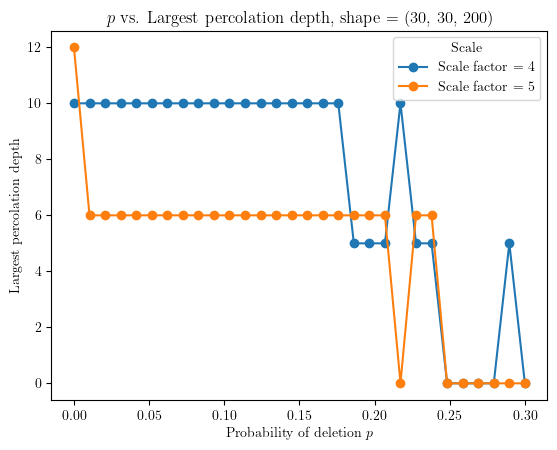

In [100]:
plt.rcParams.update({
    "text.usetex": True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern']    
    })

#df['unit_cells_ratio'] = df['unit_cells']/df['unit_cells'].max()

#plt.figure(figsize=(10, 6))
for scale in df['scale'].unique():
    subset = df[df['scale'] == scale]
    plt.plot(subset['p'], subset['diff'], marker='o', label=f'Scale factor = {scale}')


plt.title("$p$ vs. Largest percolation depth, shape = (30, 30, 200)")
plt.xlabel("Probability of deletion $p$")
plt.ylabel("Largest percolation depth")
plt.legend(title="Scale")
#plt.savefig("data/connected_cells.pdf", dpi=300, bbox_inches='tight')
plt.show()